# Import libraries

In [44]:
import pandas as pd
import re
import string
import spacy

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Get Data from Wikipedia

I follow the tutorial at https://www.mediawiki.org/wiki/API:Tutorial. I decided to use the url for wikipedia since that way I have obtained more results (at least 200 different data records needed)

In [1]:
import pandas as pd

url = 'https://en.wikipedia.org/w/api.php'

In [2]:
params = {
    "action": "query",
    "list": "mostviewed", # get most viewed articles
    "pvimlimit": 20, # limit the result to 200
    "format" : "json"
}

In [3]:
import requests
r = requests.get(url, params=params)
print(r)

<Response [200]>


In [4]:
r.json()

{'batchcomplete': '',
 'continue': {'pvimoffset': 20, 'continue': '-||'},
 'query': {'mostviewed': [{'ns': 0, 'title': 'Main Page', 'count': 4790483},
   {'ns': 0, 'title': 'Takeoff (rapper)', 'count': 1844799},
   {'ns': -1, 'title': 'Special:Search', 'count': 1325547},
   {'ns': 0, 'title': 'Migos', 'count': 802457},
   {'ns': 0, 'title': 'Quavo', 'count': 720286},
   {'ns': 0, 'title': 'Offset (rapper)', 'count': 568817},
   {'ns': 0, 'title': 'Halloween', 'count': 265501},
   {'ns': 0, 'title': "ICC Men's T20 World Cup", 'count': 231478},
   {'ns': 0, 'title': 'Jeffrey Dahmer', 'count': 190423},
   {'ns': 0, 'title': 'No Nut November', 'count': 189060},
   {'ns': 0, 'title': 'Charles Cullen', 'count': 187814},
   {'ns': 0, 'title': 'Cleopatra', 'count': 186591},
   {'ns': 0, 'title': 'Killing of Takeoff', 'count': 186518},
   {'ns': 0, 'title': 'YouTube', 'count': 179851},
   {'ns': 4, 'title': 'Wikipedia:Featured pictures', 'count': 174003},
   {'ns': 0, 'title': 'XXX: Return of X

In [5]:
# Get titles:
article_titles = []
article_views = []
for idx, x in enumerate(r.json()['query']['mostviewed']):
    # I will not include the pages "Main Page" and "Special:Search".
    if (x['title'] != 'Main Page' and x['title'] != 'Special:Search'):
        article_titles.append(x['title'])
        article_views.append(x['count'])

In [6]:
import pandas as pd
df = pd.DataFrame(columns=['Title', 'Text', 'Views'])
df['Title'] = article_titles
df['Views'] = article_views
df.head()

,Title,Text,Views
0,Takeoff (rapper),NaN,1844799
1,Migos,NaN,802457
2,Quavo,NaN,720286
3,Offset (rapper),NaN,568817
4,Halloween,NaN,265501


In [7]:
# Create a scrapper:
from bs4 import BeautifulSoup
import re

def getWikiText(html_txt):
    soup = BeautifulSoup(html_txt, 'html.parser')
    # we are interested in those that are tagged as <p> which stands for paragraphs.
    text = ''
    for paragraph in soup.find_all('p'):
        text += paragraph.text
        # Let’s do a little bit of cleaning to get the exact output from the previous section
    text = re.sub(r'\[.*?\]+', '', text)
    text = text.replace('\n', '')
    return text


In [8]:
# Request the article for each page:

for idx, title in enumerate(df['Title']):
    params = {
        "action": "parse",
        "prop": "text",
        "page": title,
        "format" : "json"
    }
    try:
        request = requests.get(url, params=params)
        if request.status_code != 200:
            raise Exception(f"Download failed with code {request.status_code}")
        else:
            df.at[idx, 'Text']= getWikiText(request.json()['parse']['text']['*'])
    except Exception as e:
        print(e)

In [9]:
df.head()

,Title,Text,Views
0,Takeoff (rapper),"Kirshnik Khari Ball (June 18, 1994 – November ...",1844799
1,Migos,Migos (/ˈmiːɡoʊs/) is an American hip hop grou...,802457
2,Quavo,"Quavious Keyate Marshall (born April 2, 1991),...",720286
3,Offset (rapper),"Kiari Kendrell Cephus (born December 14, 1991)...",568817
4,Halloween,Halloween or Hallowe'en (less commonly known a...,265501


In [10]:
df.to_csv('most_watched_wiki_articles.csv')

In [15]:
df.shape

(18, 4)

# Statistic representation

## Article lengths

In [11]:
# Get Lengths of text
for idx, article in enumerate(df['Text']):
  df.at[idx, 'Length'] = len(article)

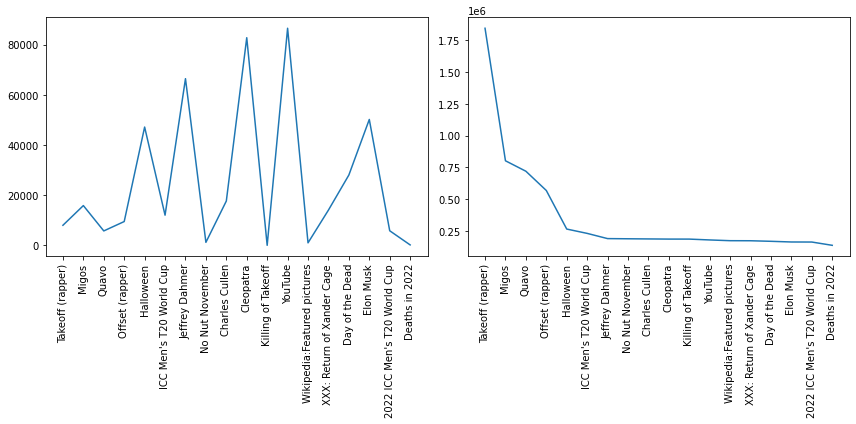

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (pic1, pic2) = plt.subplots(1, 2, figsize=(12,6))
for tick in pic1.get_xticklabels():
    tick.set_rotation(90)
for tick in pic2.get_xticklabels():
    tick.set_rotation(90)
pic1.plot(df['Title'], df['Length'])
pic2.plot(df['Title'], df['Views'])
plt.show()


## Word frequencies

I created bag of words to see which words are used in each article. 

#### Preprocess data

In [53]:
import string 

# Convert uppercase to lowercase
corpus = [document.lower() for document in df['Text']]

# Remove end of line
# corpus = [(re.sub(r'\n', '' , document)) for document in corpus]

# Remove digits
corpus = [(re.sub(r'\d', '' , document)) for document in corpus]

# Remove punctuation marks
pattern = r'[' + re.escape(string.punctuation) + ']'
corpus = [(re.sub(pattern, '' , document)) for document in corpus]
corpus = [(re.sub('–', '' , document)) for document in corpus]

# Remove superflous blanks
corpus = [(re.sub(r' +', ' ', document)) for document in corpus]

In [54]:
# Tokenize
tokens = [nltk.word_tokenize(document) for document in corpus]

In [55]:
#loading the english language of spacy and stopwords.
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Delete stopwords
tokenized_corpus = []
for document in tokens:
    tokenized_corpus.append([token for token in document if token not in sw_spacy])

In [56]:
print(tokenized_corpus[0])

['kirshnik', 'khari', 'ball', 'june', 'november', 'known', 'professionally', 'takeoff', 'american', 'rapper', 'best', 'known', 'member', 'hip', 'hop', 'trio', 'migos', 'uncle', 'quavo', 'cousin', 'removed', 'offset', 'group', 'scored', 'multiple', 'hits', 'billboard', 'hot', 'including', 'motorsport', 'featuring', 'nicki', 'minaj', 'cardi', 'b', 'stir', 'fry', 'walk', 'talk', 'featuring', 'drake', 'bad', 'boujee', 'featuring', 'lil', 'uzi', 'vert', 'peaked', 'number', 'chart', 'absence', 'song', 'resulted', 'memes', 'received', 'grammy', 'award', 'nominations', 'november', 'takeoff', 'shot', 'killed', 'houston', 'texaskirshnik', 'khari', 'ball', 'born', 'lawrenceville', 'georgia', 'miles', 'km', 'northeast', 'atlanta', 'raised', 'lawrenceville', 'mother', 'family', 'members', 'quavo', 'offsethe', 'started', 'making', 'beats', 'developing', 'rhythms', 'seventh', 'grade', 'start', 'producing', 'music', 'professionally', 'fellow', 'family', 'members', 'quavo', 'offset', 'takeoff', 'began'

In [57]:
# Lemmatize
lemmatizer = WordNetLemmatizer()
lemmatized_corpus = []
for document in tokenized_corpus:
    lemmatized_corpus.append([lemmatizer.lemmatize(token) for token in document])

In [ ]:
# Create bag of words with vectorizer


## Create a Word Cloud for the 9 most watched

Source: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

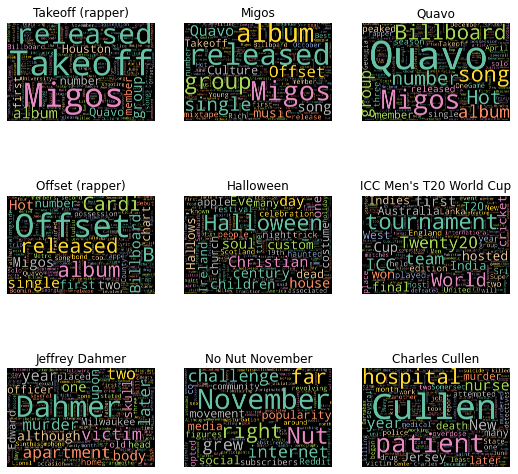

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))

for idx, text in enumerate(df['Text'][0:9]): 
  plt.subplot(3, 3, idx+1)
  wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  plt.imshow(wordcloud)
  plt.title(f"{df['Title'].iloc[idx]}")
  plt.axis('off')

# Similarity of articles

# Clustering and Machine Learning